### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
%matplotlib inline

import requests
import os
import numpy as np

import torch
import torch.nn as nn

import time
import cv2

import matplotlib.pyplot as plt

from albumentations import *
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from torchvision.models.inception import inception_v3

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [2]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [3]:
model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [4]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-0.9760,  1.1428,  2.0438,  ..., -2.2037, -0.3250,  1.6371],
        [-1.1318,  1.0819,  1.5670,  ..., -2.0653, -0.5248,  1.9191],
        [-1.1406,  0.6507,  1.2009,  ..., -2.1420, -0.4667,  1.7036],
        [-0.9151,  1.2228,  1.9588,  ..., -2.4129, -0.0774,  1.5465],
        [-1.1182,  1.0499,  1.7513,  ..., -2.2629, -0.5381,  1.8358]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


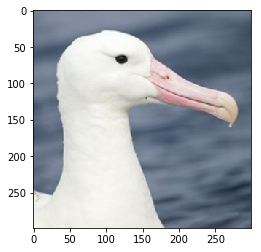

top-10 classes are: 
 [prob : class label]
0.9743 :	albatross
0.0031 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0004 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [5]:
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = imresize(plt.imread('sample_images/albatross.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img   = torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2]))
probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))

### Having fun with pre-trained nets

In [6]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2019-02-18 07:43:29--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.25.57.108, 104.25.58.108, 2606:4700:20::6819:396c, ...
Connecting to cdn.com.do (cdn.com.do)|104.25.57.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2019-02-18 07:43:29--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.25.57.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0s      

2019-02-18 07:43:29 (109 MB/s) - ‘img.jpg’ saved [51048/51048]



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


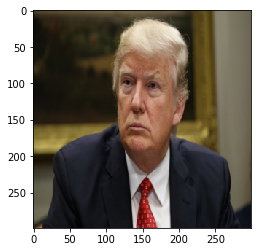

top-10 classes are: 
 [prob : class label]
0.7018 :	suit
0.0972 :	Windsor tie
0.0573 :	groom
0.0043 :	oboe
0.0040 :	academic gown
0.0038 :	Loafer
0.0032 :	Afghan hound
0.0029 :	wig
0.0028 :	Sussex spaniel


In [6]:
img = imresize(plt.imread('img.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img   = torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2]))
probs = torch.nn.functional.softmax(model(img), dim=-1)
probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [8]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

--2019-02-18 07:44:05--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/d61lupw909hc785/dogs_vs_cats.train.zip [following]
--2019-02-18 07:44:05--  https://www.dropbox.com/s/dl/d61lupw909hc785/dogs_vs_cats.train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc403149781591aed3839c03782a.dl.dropboxusercontent.com/cd/0/get/AbjFjJKw0CR33sV1-VblbnMVca8otHEIvM1L-fD6ahWpYHKycEtCen1xObxEJ8V2_5-bZykl8ZfcgBg8v6YKeaGlXvj4ccJqrvNT4Kh6aHuw9sV6sG4VbQHIJuDHR9ZGumQ/file?dl=1# [following]
--2019-02-18 07:44:06--  https://uc403149781591aed3839c03782a.dl.dropboxusercontent.com/cd/0/get/AbjFjJKw0CR33sV1-VblbnMVca8otHEIvM1L-fD6ahWpYHKycEtCen1xObxEJ8V2_5-bZykl8ZfcgBg8v6

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [9]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(img).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [17]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imread, imresize
import numpy as np

X = []
Y = []

batch_size = 64
imgs       = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.FloatTensor(imgs.transpose([0,3,1,2]))
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor)
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

  0%|          | 0/25000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  0%|          | 111/25000 [00:12<35:43, 11.61it/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

In [ ]:
<split data here or use cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
<YOUR CODE>

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

#### Define Model

In [3]:
model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.fc = nn.Linear(2048, 2)

model     = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()

In [4]:
image_names = os.listdir('./train/')

val_image_names   = np.random.choice(image_names, size=int(.1 * len(image_names)), replace=False)
test_image_names  = np.random.choice(list(set(image_names) - set(val_image_names)), 
                                    size=int(.1 * len(image_names)), replace=False)
train_image_names = list(set(image_names) - set(val_image_names) - set(test_image_names))

print(len(train_image_names), ' ', len(val_image_names), ' ', len(test_image_names))

20000   2500   2500


#### Data Loader

In [5]:
def compute_accuracy(logits, targets):
    _, preds = torch.max(logits.data, dim=1)
    
    return (preds == targets).sum()

In [6]:
class DogsCatsDataset(Dataset):
    """Dogs and Cats dataset."""

    def __init__(self, filenames, root_dir, transform=None):
        """
        Args:
            filename (list)  : List of filenames.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_names = filenames
        self.root_dir    = root_dir
        self.transform   = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.image_names[idx])
        
        target = torch.LongTensor(np.array([self.image_names[idx].split('.')[0] == 'cat'], dtype=int)) 
        image  = cv2.imread(img_name)
        image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            
        return image, target

In [7]:
# define transforms
train_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([299,299]),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                   ])

test_transforms  = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([299,299]),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                   ])

In [8]:
# define datasets
train_dataset  = DogsCatsDataset(train_image_names, './train', transform=train_transforms)
valid_dataset  = DogsCatsDataset(val_image_names, './train', transform=test_transforms)
test_dataset   = DogsCatsDataset(test_image_names, './train', transform=test_transforms)

# define batch size
batch_size     = 32

# define data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_data_loader  = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

In [9]:
# define an optimizer
opt             = torch.optim.Adam(model.parameters())
num_epochs      = 2 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    
    training_loss   = 0.
    validation_loss = 0.
    correct         = 0.
    total           = 0.

    model.train(True) # enable dropout / batch_norm training behavior
    print('Training ...')
    
    for i, (x_batch, y_batch) in enumerate(train_data_loader, 0):
        x_batch = x_batch.cuda()
        y_batch = y_batch.squeeze().cuda()
        
        logits    = model(x_batch)
        loss      = criterion(logits, y_batch)
    
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        # print statistics
        training_loss += loss.cpu().detach().item()
        
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, training_loss / len(logits)))
            
            training_loss = 0.0
    
    print('Validation ...')
    model.train(False)
    
    for i, (x_batch, y_batch) in enumerate(valid_data_loader, 0):
        x_batch = x_batch.cuda()
        y_batch = y_batch.squeeze().cuda()
        
        logits    = model(x_batch)
        loss      = criterion(logits, y_batch)
        
        val_acc   = compute_accuracy(logits, y_batch)
        val_acc   = val_acc.cpu().detach().item()
        correct   += val_acc
        total     += len(logits)
        
        validation_loss += loss.cpu().detach().item()
        
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, validation_loss / len(logits)))
            
            validation_loss = 0.0
    
    print('acc: %.3f'%((100 * correct) / total))
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

Training ...
[1,     1] loss: 0.024
[1,    51] loss: 0.414
[1,   101] loss: 0.331
[1,   151] loss: 0.284
[1,   201] loss: 0.255
[1,   251] loss: 0.264
[1,   301] loss: 0.309
[1,   351] loss: 0.252
[1,   401] loss: 0.248
[1,   451] loss: 0.212
[1,   501] loss: 0.212
[1,   551] loss: 0.214
[1,   601] loss: 0.159
Validation ...
[1,     1] loss: 0.006
[1,    51] loss: 0.161
acc: 96.280
Epoch 1 of 2 took 370.946s
Training ...
[2,     1] loss: 0.003
[2,    51] loss: 0.142
[2,   101] loss: 0.174
[2,   151] loss: 0.155
[2,   201] loss: 0.183
[2,   251] loss: 0.177
[2,   301] loss: 0.216
[2,   351] loss: 0.149
[2,   401] loss: 0.125
[2,   451] loss: 0.225
[2,   501] loss: 0.155
[2,   551] loss: 0.178
[2,   601] loss: 0.156
Validation ...
[2,     1] loss: 0.008
[2,    51] loss: 0.127
acc: 96.640
Epoch 2 of 2 took 375.473s


### Model with custom head

In [15]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class CustomModel(nn.Module):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        
        self.body    = model
        self.body.fc = Identity()
        self.head    = nn.Sequential(
                         nn.Linear(2048, 1000),
                         nn.ReLU(),
                         nn.Linear(1000, 2)
                       )
        
    def forward(self, x):
        body_output = self.body(x)
        output      = self.head(body_output)
        
        return output

In [16]:
model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)

custom_model = CustomModel(model).cuda()
criterion    = nn.CrossEntropyLoss().cuda()

In [17]:
# define an optimizer
opt             = torch.optim.Adam(custom_model.head.parameters())
num_epochs      = 2 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    
    training_loss   = 0.
    validation_loss = 0.
    correct         = 0.
    total           = 0.

    custom_model.train(True) # enable dropout / batch_norm training behavior
    print('Training ...')
    
    for i, (x_batch, y_batch) in enumerate(train_data_loader, 0):
        x_batch = x_batch.cuda()
        y_batch = y_batch.squeeze().cuda()
        
        logits    = custom_model(x_batch)
        loss      = criterion(logits, y_batch)
    
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        # print statistics
        training_loss += loss.cpu().detach().item()
        
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, training_loss / len(logits)))
            
            training_loss = 0.0
    
    print('Validation ...')
    custom_model.train(False)
    
    for i, (x_batch, y_batch) in enumerate(valid_data_loader, 0):
        x_batch = x_batch.cuda()
        y_batch = y_batch.squeeze().cuda()
        
        logits    = custom_model(x_batch)
        loss      = criterion(logits, y_batch)
        
        val_acc   = compute_accuracy(logits, y_batch)
        val_acc   = val_acc.cpu().detach().item()
        correct   += val_acc
        total     += len(logits)
        
        validation_loss += loss.cpu().detach().item()
        
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, validation_loss / len(logits)))
            
            validation_loss = 0.0
    
    print('acc: %.3f'%((100 * correct) / total))
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

Training ...
[1,     1] loss: 0.022
[1,    51] loss: 0.489
[1,   101] loss: 0.200
[1,   151] loss: 0.196
[1,   201] loss: 0.245
[1,   251] loss: 0.193
[1,   301] loss: 0.175
[1,   351] loss: 0.204
[1,   401] loss: 0.187
[1,   451] loss: 0.180
[1,   501] loss: 0.163
[1,   551] loss: 0.153
[1,   601] loss: 0.165
Validation ...
[1,     1] loss: 0.005
[1,    51] loss: 0.149
acc: 95.680
Epoch 1 of 2 took 364.472s
Training ...
[2,     1] loss: 0.001
[2,    51] loss: 0.224
[2,   101] loss: 0.183
[2,   151] loss: 0.241
[2,   201] loss: 0.136
[2,   251] loss: 0.138
[2,   301] loss: 0.183
[2,   351] loss: 0.167
[2,   401] loss: 0.163
[2,   451] loss: 0.130
[2,   501] loss: 0.195
[2,   551] loss: 0.153
[2,   601] loss: 0.149
Validation ...
[2,     1] loss: 0.003
[2,    51] loss: 0.088
acc: 97.840
Epoch 2 of 2 took 368.865s


In [18]:
print('Testing ...')
custom_model.train(False)
    
test_acc = 0.
correct  = 0.
total    = 0.

for i, (x_batch, y_batch) in enumerate(test_data_loader, 0):
    x_batch = x_batch.cuda()
    y_batch = y_batch.squeeze().cuda()

    logits    = custom_model(x_batch)
    loss      = criterion(logits, y_batch)

    test_acc   = compute_accuracy(logits, y_batch)
    test_acc   = test_acc.cpu().detach().item()
    correct   += test_acc
    total     += len(logits)

print('acc: %.3f'%((100 * correct) / total))

Testing ...
acc: 98.120


# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [3]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
from torchvision.models import vgg16

import numpy as np

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
    
# class DeepDreamModel(nn.Module):
#     def __init__(self, features):
#         super(DeepDreamModel, self).__init__()
        
#         self.features   = features
#         self.avgpool    = nn.AdaptiveAvgPool2d((7, 7))
#         self.classifier = nn.Linear(512 * 7 * 7, 1000)
        
#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

In [5]:
model             = vgg16(pretrained=True)
# model.avgpool     = nn.AdaptiveAvgPool2d((7, 7))
# model.flatten     = Flatten()
# model.classifier  = nn.Linear(512 * 7 * 7, 1000)

model.classifier = nn.Sequential(
                        nn.AdaptiveAvgPool2d((7, 7)),
                        Flatten(),
                        nn.Linear(512 * 7 * 7, 1000)
                    )
model = model.cuda()

In [6]:
modulelist = list(model.features.modules())[1:] + list(model.classifier.modules())[1:]

In [173]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()
    ])

def dd_helper(image, layer, iterations, lr):        
    
    input_var = preprocess(image).unsqueeze(0).cuda()
    input_var.requires_grad = True
    
    model.zero_grad()
    
    for i in range(iterations):
        out = input_var
        
        for j in range(layer):
            out = modulelist[j](out)
        
        loss = (out[0][954]).cuda()
#         loss = nn.CrossEntropyLoss().cuda()(out, torch.cuda.LongTensor([954]))
        
#         if i % 200 == 0:
#             print(loss)
#         loss = out.norm()
        
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0,1)
    input_im.transpose_(1,2)
    input_im = input_im.cpu().detach().numpy()
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [174]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
        
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size   = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image  = ImageChops.blend(image, image1, 0.6)
    
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    
    plt.imshow(img_result)
    return img_result

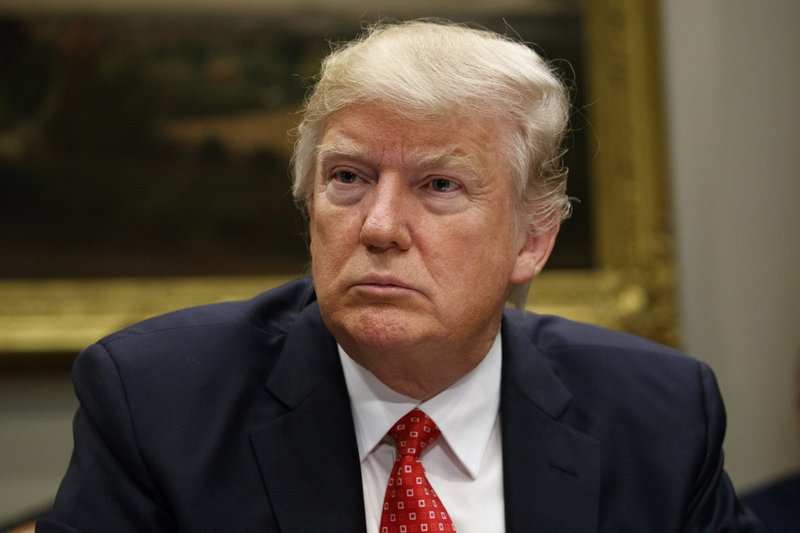

In [52]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [25]:
img.size

(800, 533)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------


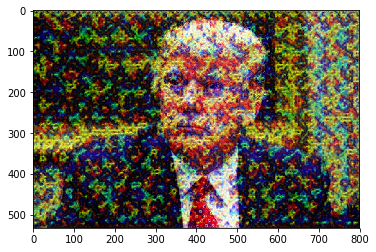

In [52]:
# output = deep_dream_vgg(img, 5, 5, 0.3, 2, 4)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------


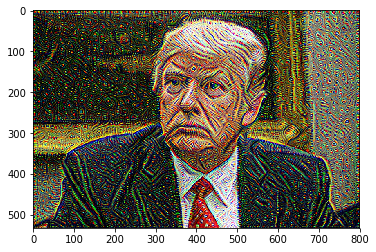

In [53]:
# output = deep_dream_vgg(img, 12, 5, 0.2, 2, 1)

-------------- Recursive level:  0 --------------
tensor(10.2493, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(10.2493, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(10.2492, device='cuda:0', grad_fn=<NllLossBackward>)
-------------- Recursive level:  1 --------------
tensor(10.2621, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(10.2412, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(10.2206, device='cuda:0', grad_fn=<NllLossBackward>)
-------------- Recursive level:  2 --------------
tensor(10.1964, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.6137, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.2574, device='cuda:0', grad_fn=<NllLossBackward>)
-------------- Recursive level:  3 --------------
tensor(10.1161, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(8.1384, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6.8771, device='cuda:0', grad_fn=<NllLossBackward>)
-------------- Recursive level:  4 --------------
tensor(11.0973, device='cuda:0', g

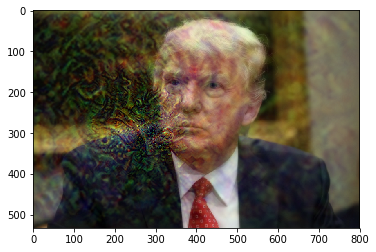

In [139]:
#can you implement one class probability optimization to make model dream about bananas
output = deep_dream_vgg(img, 33, 50, .01, 2, 8)